Importing all necessary libraries

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import tkinter as tk
from tkinter import messagebox
import numpy as np
import joblib


Running Correlation Test

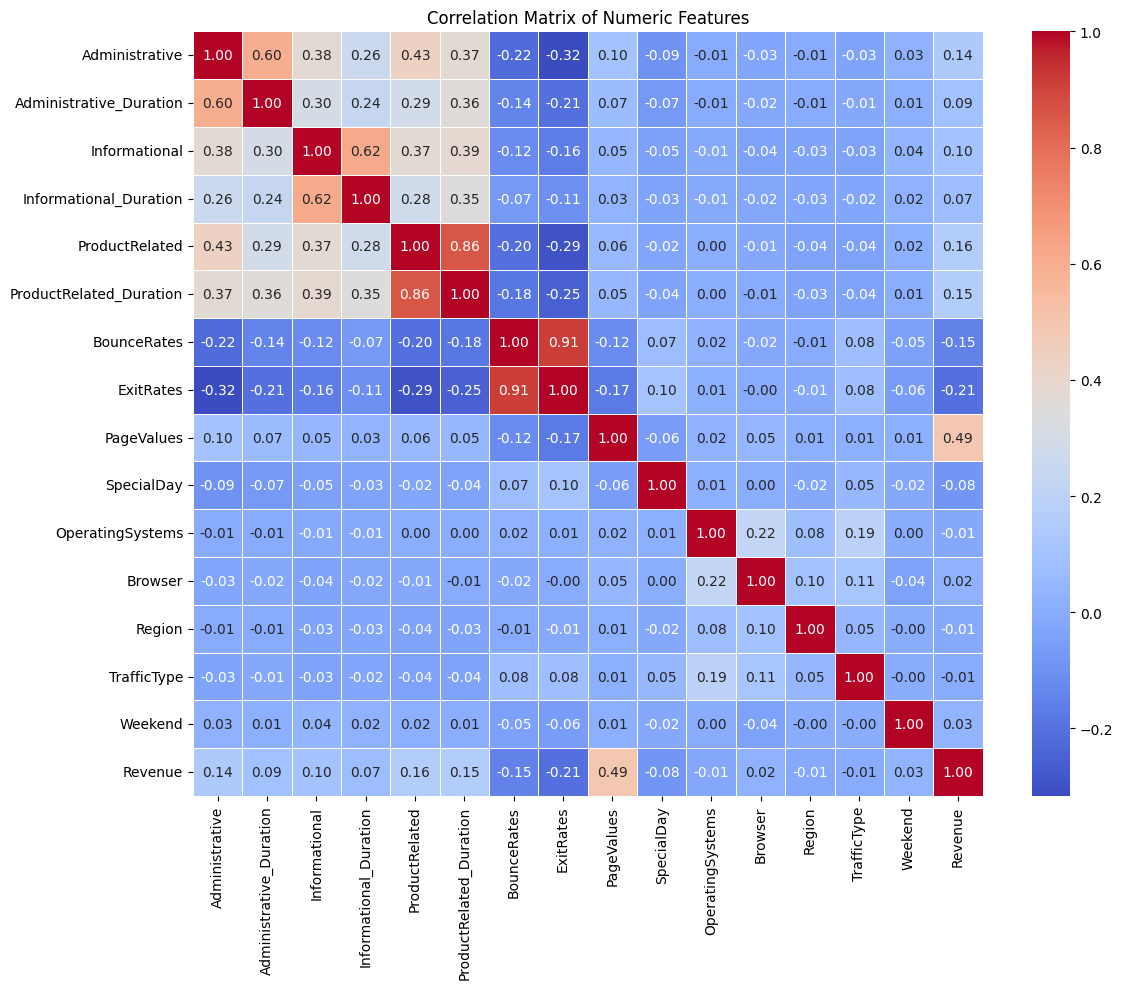

In [31]:
# Import Dataset
df = pd.read_csv("Data/online_shoppers_intention.csv")

# Compute the correlation matrix for numeric variables
correlation_matrix = df.corr(numeric_only=True)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

Feature Selection and Engineering

In [32]:
# Convert 'Weekend' to boolean explicitly
df['Weekend'] = df['Weekend'].astype(bool)

# Treat these columns as nominal categorical
nominal_cols = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
df[nominal_cols] = df[nominal_cols].astype('category')

# Copy the dataframe to work on
df_model = df.copy()

# Encode categorical variables
label_encoders = {}
for col in df_model.select_dtypes(include=['object', 'bool']).columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Define features and target
X = df_model.drop(columns=['Revenue'])
y = df_model['Revenue']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances

PageValues                 0.382999
ExitRates                  0.088494
ProductRelated_Duration    0.086812
ProductRelated             0.071784
BounceRates                0.058643
Administrative_Duration    0.057753
Administrative             0.045017
Month                      0.042737
TrafficType                0.031722
Region                     0.028817
Informational_Duration     0.028441
Browser                    0.017857
Informational              0.017347
OperatingSystems           0.016831
VisitorType                0.012520
Weekend                    0.009352
SpecialDay                 0.002873
dtype: float64

In [33]:
# Create engineered features
df_fe = df_model.copy()

# 1. Behavioral Intensity
df_fe['ProductViewRate'] = df_fe['ProductRelated_Duration'] / (df_fe['ProductRelated'] + 1)
df_fe['InfoViewRate'] = df_fe['Informational_Duration'] / (df_fe['Informational'] + 1)

# 2. Efficiency Metrics
df_fe['EngagementScore'] = df_fe['PageValues'] / (df_fe['ExitRates'] + 0.01)
df_fe['ConversionReadiness'] = df_fe['PageValues'] * df_fe['SpecialDay']

# 3. Binary Flags
df_fe['IsHighlyEngaged'] = (df_fe['ProductRelated_Duration'] > 1000).astype(int)
df_fe['IsPromoTiming'] = (df_fe['SpecialDay'] > 0).astype(int)

# 4. Interaction Terms
df_fe['Bounce_Exit_Combo'] = df_fe['BounceRates'] * df_fe['ExitRates']
df_fe['AdministrativeProductRatio'] = df_fe['Administrative'] / (df_fe['ProductRelated'] + 1)

# 5. Temporal Simplification
# Decode month back from encoded values
month_le = df_fe['Month']
df_fe['IsHolidaySeason'] = df['Month'].isin(['Nov', 'Dec']).astype(int)

# Run Random Forest again with engineered features
X_fe = df_fe.drop(columns=['Revenue'])
y_fe = df_fe['Revenue']

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.4, random_state=42)

rf_fe = RandomForestClassifier(n_estimators=100, random_state=42)
rf_fe.fit(X_train_fe, y_train_fe)

# Feature importances after engineering
fe_importances = pd.Series(rf_fe.feature_importances_, index=X_fe.columns).sort_values(ascending=False)

fe_importances.head(20)

EngagementScore               0.228672
PageValues                    0.191622
ProductRelated_Duration       0.062376
ExitRates                     0.054986
ProductViewRate               0.050038
ProductRelated                0.048117
AdministrativeProductRatio    0.040773
Administrative_Duration       0.040343
BounceRates                   0.038412
Bounce_Exit_Combo             0.037444
Administrative                0.031396
Month                         0.028996
TrafficType                   0.021266
Region                        0.020805
InfoViewRate                  0.016716
Informational_Duration        0.016296
OperatingSystems              0.013245
Browser                       0.012282
Informational                 0.010930
IsHolidaySeason               0.010543
dtype: float64

Building Model Without Oversampling

In [38]:
# Feature engineering
df_model['EngagementScore'] = df_model['PageValues'] / (df_model['ExitRates'] + 0.01)

# Feature selection
features = ['PageValues', 'EngagementScore', 'ExitRates', 'ProductRelated_Duration',
            'ProductRelated', 'Administrative', 'Administrative_Duration', 'BounceRates']
X = df_model[features]
y = df_model['Revenue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Load and prepare data
for col in df.select_dtypes(include=['object', 'bool']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])
df['EngagementScore'] = df['PageValues'] / (df['ExitRates'] + 0.01)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(max_depth=10, n_estimators=120, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Evaluation function
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    misclassification_rate = 1 - accuracy
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    return {
        "Model": name,
        "Misclassification Rate": misclassification_rate,
        "False Positive Rate": false_positive_rate,
        "False Negative Rate": false_negative_rate
    }

# Evaluate all models
results = [evaluate_model(name, model, X_train, X_test, y_train, y_test) for name, model in models.items()]
results_df = pd.DataFrame(results)

results_df


,Model,Misclassification Rate,False Positive Rate,False Negative Rate
0,Logistic Regression,0.119424,0.019904,0.664042
1,Random Forest,0.108475,0.042446,0.469816
2,Gradient Boosting,0.107056,0.041966,0.463255


Build Models After Oversampling

In [ ]:
# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder
df_model = df.copy()
for col in df_model.select_dtypes(include=['object', 'bool']).columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Misclassification Rate:", 1 - accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Misclassification Rate: 0.12793998377939986
Confusion Matrix:
 [[3752  418]
 [ 213  549]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92      4170
           1       0.57      0.72      0.64       762

    accuracy                           0.87      4932
   macro avg       0.76      0.81      0.78      4932
weighted avg       0.89      0.87      0.88      4932



In [35]:
rf_model = RandomForestClassifier(max_depth=10, n_estimators=120, random_state=42)
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test)
print("Misclassification Rate:", 1 - accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Misclassification Rate: 0.12591240875912413
Confusion Matrix:
 [[3714  456]
 [ 165  597]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      4170
           1       0.57      0.78      0.66       762

    accuracy                           0.87      4932
   macro avg       0.76      0.84      0.79      4932
weighted avg       0.90      0.87      0.88      4932



In [36]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = gb_model.predict(X_test)
print("Misclassification Rate:", 1 - accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Misclassification Rate: 0.12631792376317919
Confusion Matrix:
 [[3723  447]
 [ 176  586]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      4170
           1       0.57      0.77      0.65       762

    accuracy                           0.87      4932
   macro avg       0.76      0.83      0.79      4932
weighted avg       0.89      0.87      0.88      4932



In [29]:
joblib.dump(rf_model, "RandomForest_model.pkl")

['RandomForest_model.pkl']

Create Tkinter Interface

In [ ]:
# Load your trained gradient boosting model
model = joblib.load("RandomForest_model.pkl")

root = tk.Tk()
root.title("Purchase Intent Predictor")
root.geometry("450x550")

# Variables
fields = {
    "PageValues": tk.DoubleVar(),
    "ExitRates": tk.DoubleVar(),
    "ProductRelated_Duration": tk.DoubleVar(),
    "ProductRelated": tk.IntVar(),
    "Administrative": tk.IntVar(),
    "Administrative_Duration": tk.DoubleVar(),
    "BounceRates": tk.DoubleVar()
}
engagement_score_var = tk.StringVar(value="0.0")

# Layout
row = 0
for label, var in fields.items():
    tk.Label(root, text=label).grid(row=row, column=0, padx=10, pady=5, sticky='w')
    entry = tk.Entry(root, textvariable=var, width=30)
    entry.grid(row=row, column=1)

    # Auto-update Engagement Score if input changes
    if label in ["PageValues", "ExitRates"]:
        var.trace_add("write", lambda *args: update_engagement_score())
    row += 1

# Read-only Engagement Score Display
tk.Label(root, text="EngagementScore (auto)").grid(row=row, column=0, padx=10, pady=5, sticky='w')
tk.Entry(root, textvariable=engagement_score_var, width=30, state="readonly").grid(row=row, column=1)
row += 1

def update_engagement_score():
    try:
        pv = fields["PageValues"].get()
        er = fields["ExitRates"].get()
        engagement = pv / (er + 0.01)
        engagement_score_var.set(f"{engagement:.4f}")
    except:
        engagement_score_var.set("0.0")

def predict():
    try:
        input_data = np.array([[
            fields["PageValues"].get(),
            float(engagement_score_var.get()),
            fields["ExitRates"].get(),
            fields["ProductRelated_Duration"].get(),
            fields["ProductRelated"].get(),
            fields["Administrative"].get(),
            fields["Administrative_Duration"].get(),
            fields["BounceRates"].get()
        ]])
        prob = model.predict_proba(input_data)[0][1]
        threshold = 0.7

        if prob >= threshold:
            messagebox.showinfo("Result", f"✅ Likely to Make a Purchase\nConfidence: {prob:.2f}")
        else:
            messagebox.showinfo("Result", f"❌ Not Likely to Make a Purchase\nConfidence: {prob:.2f}")
    except Exception as e:
        messagebox.showerror("Error", f"Input or prediction error:\n{e}")

# Predict Button
tk.Button(root, text="Predict Purchase Intent", command=predict, bg="blue", fg="white").grid(row=row, columnspan=2, pady=20)

root.mainloop()